## Define the Convolutional Neural Network

In this notebook and in `models.py`, we will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

We will use the multiple of the above layers. The structure of our model is inspired by [this paper](https://arxiv.org/pdf/1710.00977.pdf).

---

## PyTorch Neural Nets

To define a neural network in PyTorch, we define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
A conv/pool layer is defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

We are defining the network in the `models.py` file so that any models we define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, we can create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2018-12-11 03:39:12--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.81.51
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.81.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  46.8MB/s    in 6.1s    

2018-12-11 03:39:18 (53.3 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10.j

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, we will create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so our model's loss does not blow up during training, we will normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py`.

To define the data transform below, we will use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that we are left with a square image (size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## Define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that we've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

In [6]:
# load training data in batches
batch_size = 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)


## Before training

Let's take a look at how this model performs before it trains. We can see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that we can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)


In [8]:
# load test data in batches
batch_size = 40

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, we will follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 224, 224])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

We've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, we define a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; we will apply these transformations when we loaded our test data.

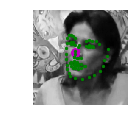

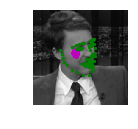

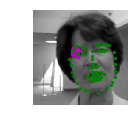

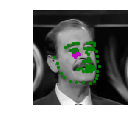

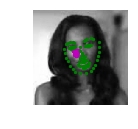

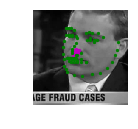

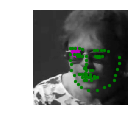

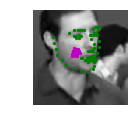

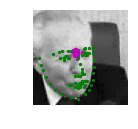

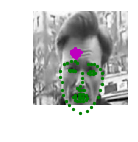

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we will choose a loss function that is suited for regression, which directly compares a predicted value and target value.

### Define the loss and optimization

Next, we'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(),lr = 0.0001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training and Initial Observation

Now, we'll train on our batched training data from `train_loader` for a number of epochs. 

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes we already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 20

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.1421689435839653
Epoch: 1, Batch: 20, Avg. Loss: 0.10278835892677307
Epoch: 1, Batch: 30, Avg. Loss: 0.09809436053037643
Epoch: 1, Batch: 40, Avg. Loss: 0.11137844845652581
Epoch: 1, Batch: 50, Avg. Loss: 0.08797746896743774
Epoch: 1, Batch: 60, Avg. Loss: 0.07916747406125069
Epoch: 1, Batch: 70, Avg. Loss: 0.09259209558367729
Epoch: 1, Batch: 80, Avg. Loss: 0.0790744286030531
Epoch: 2, Batch: 10, Avg. Loss: 0.07467319555580616
Epoch: 2, Batch: 20, Avg. Loss: 0.0670518085360527
Epoch: 2, Batch: 30, Avg. Loss: 0.06081119291484356
Epoch: 2, Batch: 40, Avg. Loss: 0.06450814716517925
Epoch: 2, Batch: 50, Avg. Loss: 0.06549832932651042
Epoch: 2, Batch: 60, Avg. Loss: 0.061218688264489174
Epoch: 2, Batch: 70, Avg. Loss: 0.057790706679224965
Epoch: 2, Batch: 80, Avg. Loss: 0.059476186707615855
Epoch: 3, Batch: 10, Avg. Loss: 0.055060353875160215
Epoch: 3, Batch: 20, Avg. Loss: 0.05025849565863609
Epoch: 3, Batch: 30, Avg. Loss: 0.05720449797809124
Epoch: 3, B

## Test data

See how our model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run our trained model on these images to see what kind of keypoints are produced. We should be able to see if our model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 224, 224])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


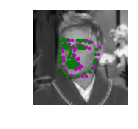

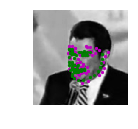

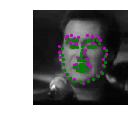

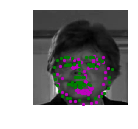

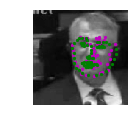

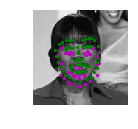

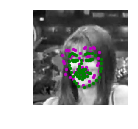

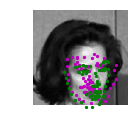

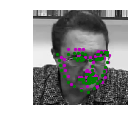

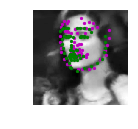

In [17]:
## Visualize your test output

visualize_output(test_images, test_outputs, gt_pts)


In [18]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save our model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Explanations for how we construct the model?
### 1: Optimization and loss functions

**Explanations**: I chose Adam for optimization and SmoothL1Loss for loss function. 

The reasons why I chose SmoothL1Loss are: 
1. it's suited for regression. 
2. it's less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

The reason why I chose Adam (adaptive moment estimation, which uses past gradients to calculate current gradients) are: it's pretty widespread, and is practically accepted for use in training neural nets. On average, it performs better than other optimizer on CNN/Neural network.

### 2: Network architecture

**Explanations**: I started my model with 2 convolutional layers (each convolutional layer is followed by a max pooling layer and a dropout layer) and 2 fully connected layer. After I studied the paper https://arxiv.org/pdf/1710.00977.pdf suggested above, I added 3 more convolutional layers (and max pooling/dropout layers), and retest. The latter architecture got lower loss values in first few epochs. The loss did not go down after certain epoch, so I changed the loss function from MSELoss to SmoothL1Loss, the optimizer from SGD to Adam, and most important, the activation functions from relu to selu (Scaled Exponential Linear Unit (SELU) activation function). I saw loss going down and visualizing the test outputs. The model seems to work.

### 3: Number of epochs and batch_size

**Explanations**: I decided the number of epochs by looking at the training time/loss and visualizing the test outputs. I trained my model for 10 epochs, and it took more than 3 hours. I used Udacity's workspace - no GPU is allocated for this project. The loss at the end of the training is 0.05, and we can tell the test outputs are much closer to the ground truth labels compared to the test outputs before the training started. I think the performance of my model can still be improved if I train more epochs, but I ran out of time, so just stop after training for 10 epochs.

I decided the batch_size by comparing the loss when using batch_size 10, 20, 40 and 64.
When I use batch_size 10 or 20, loss did not go down after certain epoch, when I use batch_size 64, I did not see first outputs even after 20 minutes (took too much memory or took too long for the processing?). So I decided to use batch_size 40.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and we can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

**Note:** the model was tried and saved a fews days ago. Below I just load the save model and the weights.

In [19]:
import torch
from models import Net

net = Net()

net.load_state_dict(torch.load('saved_models/keypoints_model_2.pt'))

## print out the net and prepare it for testing
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop): Dropout(p=0.4)
)

[[ 0.13467322  0.1042994  -0.07516719 -0.09007832  0.0302237 ]
 [ 0.20830524 -0.13372101  0.06762167  0.03325671 -0.15231982]
 [-0.17606068  0.18896051 -0.15796833  0.1460827  -0.10517829]
 [-0.11712248  0.01232729  0.19040327  0.01495816 -0.15299708]
 [ 0.1425987  -0.17936897  0.13314933 -0.02720638  0.06401592]]
(5, 5)


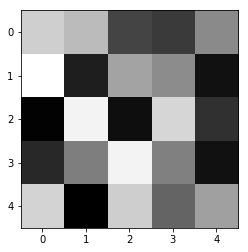

In [18]:
# Get the weights in the first conv layer, "conv1"
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, we might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, we might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in our trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

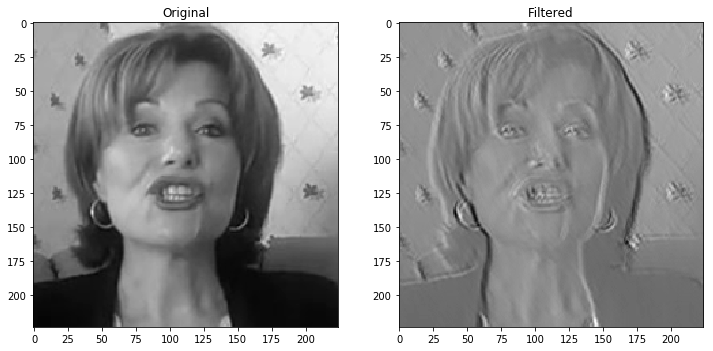

In [20]:
import cv2
img = test_dataset[10]
img = img["image"].data.numpy().reshape(224,224)

## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
dst = cv2.filter2D(img,-1,w[filter_index][0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.set_title('Original')
ax2.set_title('Filtered')
ax1.imshow(img,cmap='gray')
ax2.imshow(dst,cmap='gray')

**Observations**: from the way it brings out the lines in the image, I think this as an edge detection filter which helps to define the face.

---
## Moving on!

Now that we've defined and trained our model (and saved the best model), we are ready to move on to the last notebook, which combines a face detector with our saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!